# Imports

In [40]:
import dataset_loader as dl
import datasets_from_loader_utils as dflu

import numpy as np

import matplotlib.pyplot as plt

import tensorflow as tf
layers = tf.keras.layers

import cv2
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay


In [41]:
dl.IMAGE_SIZE = 128
dl.BATCH_SIZE = 32

In [42]:
coco_train = dl.coco_RGB_dataset_precomputed(
    split='train',
    channels=1
)

coco_val = dl.coco_RGB_dataset_precomputed(
    split='val',
    channels=1
)

# Check masks

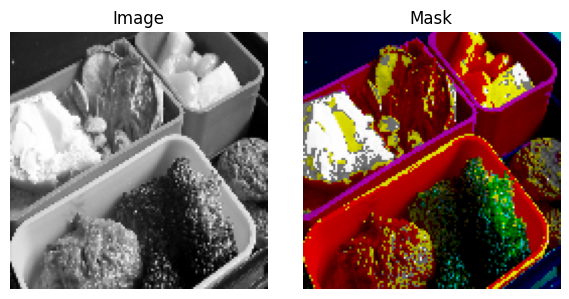

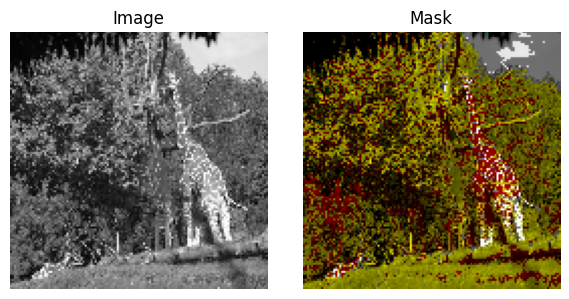

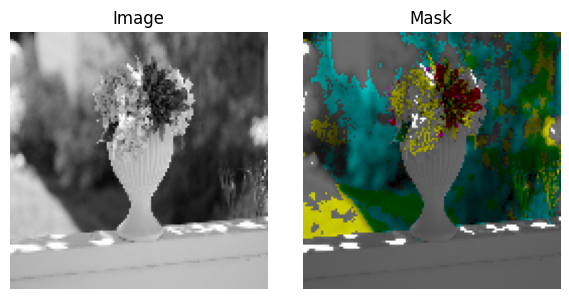

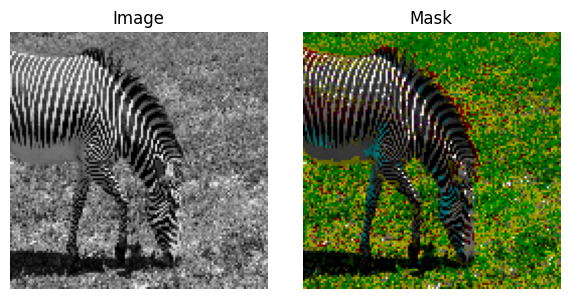

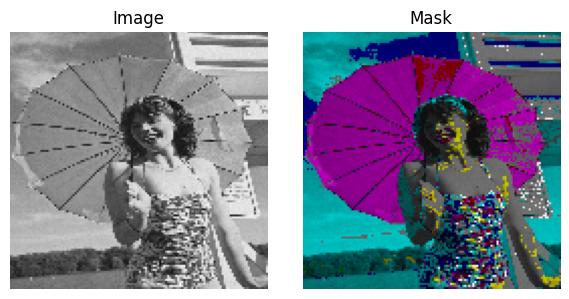

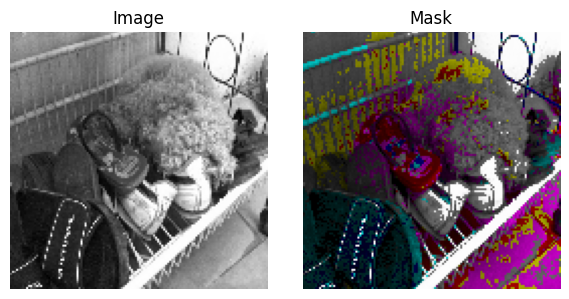

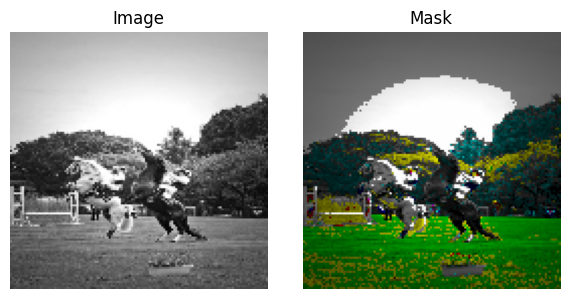

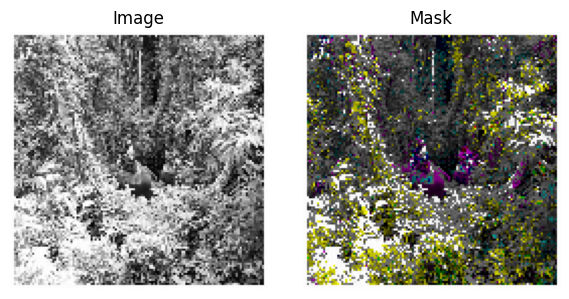

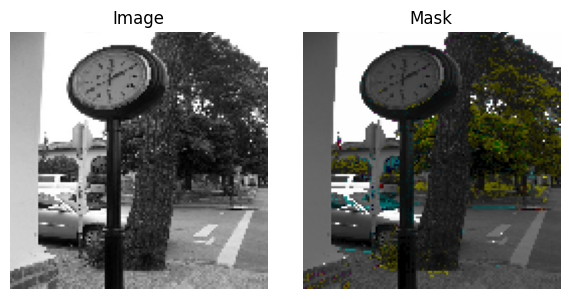

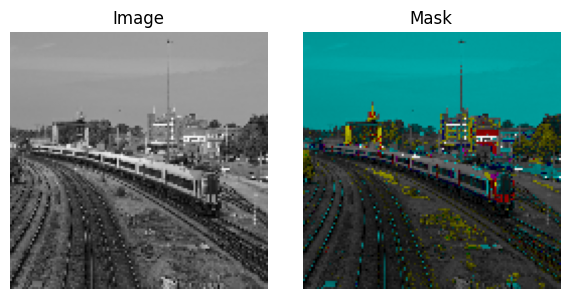

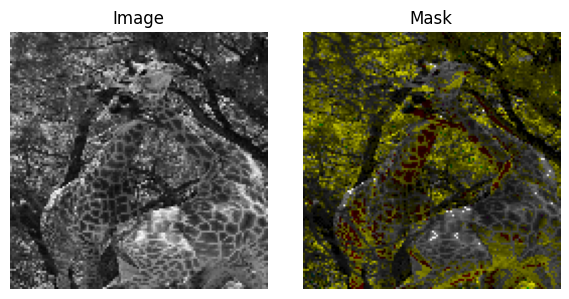

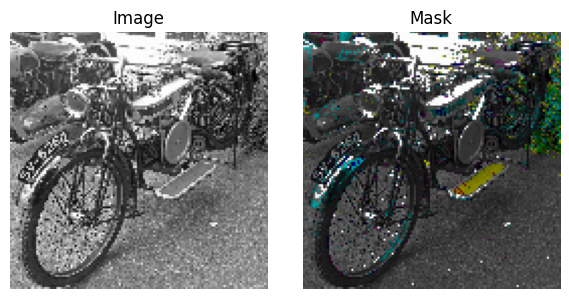

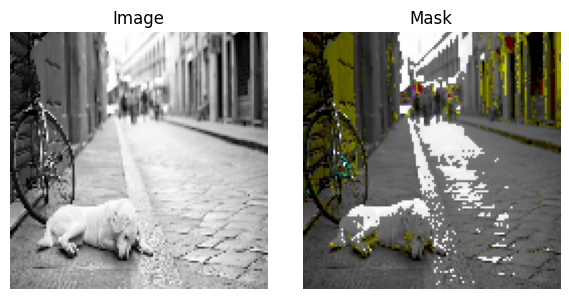

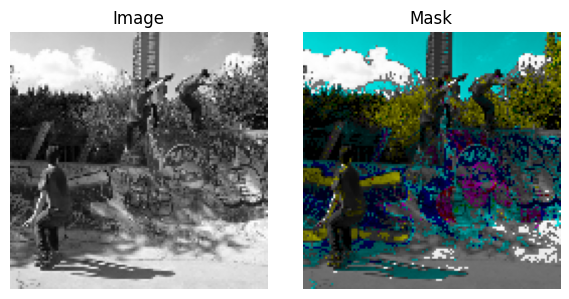

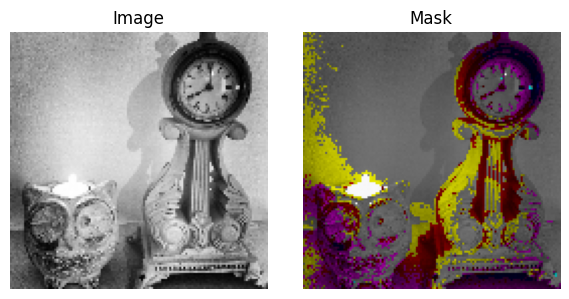

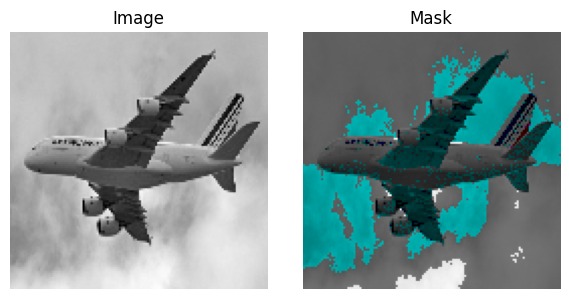

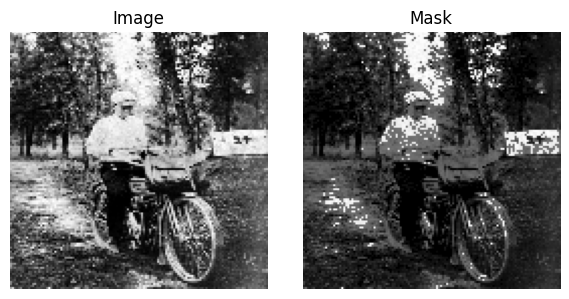

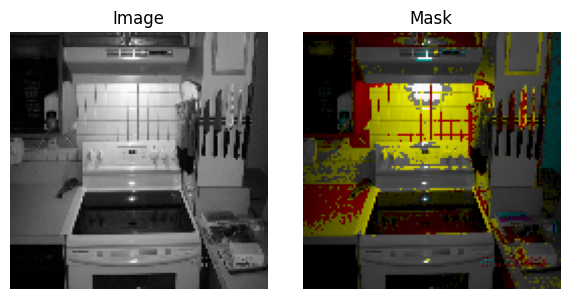

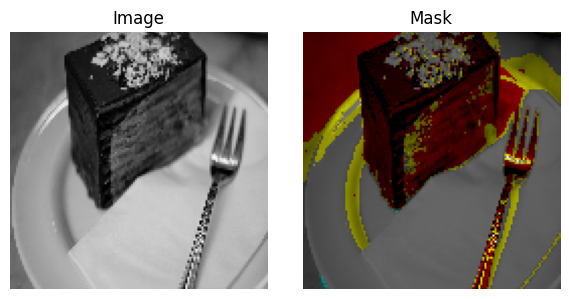

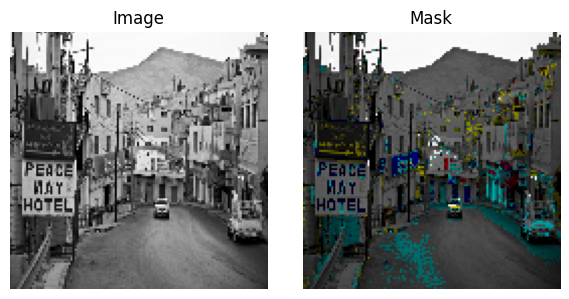

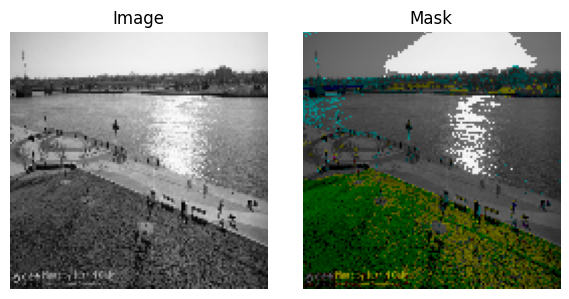

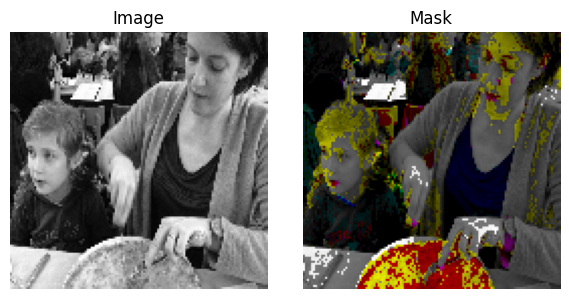

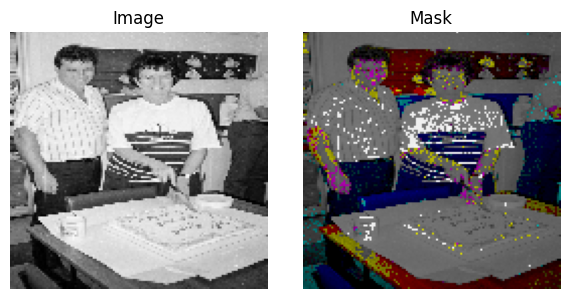

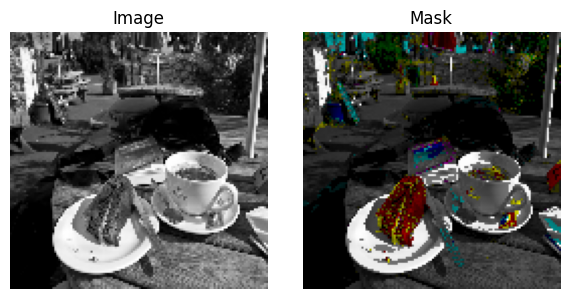

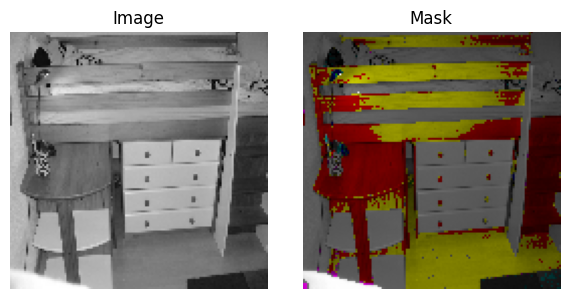

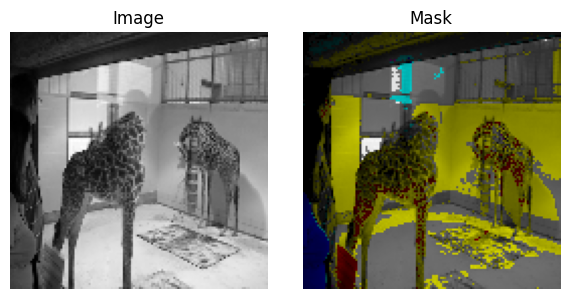

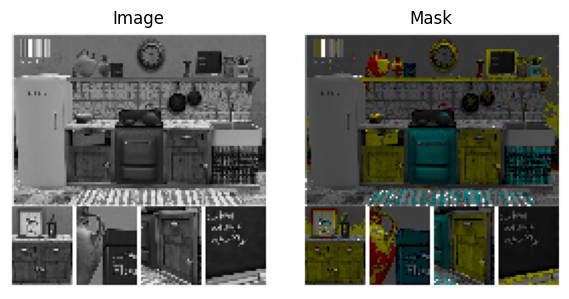

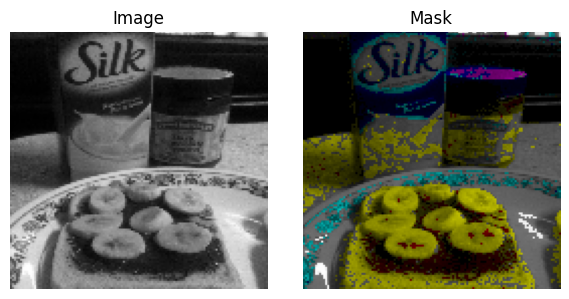

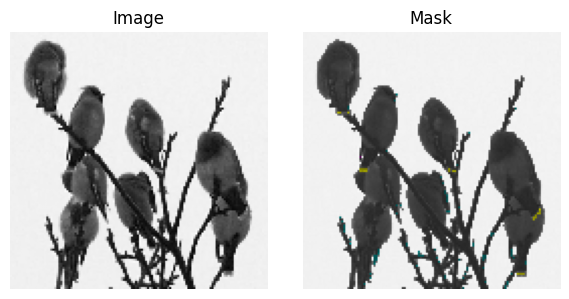

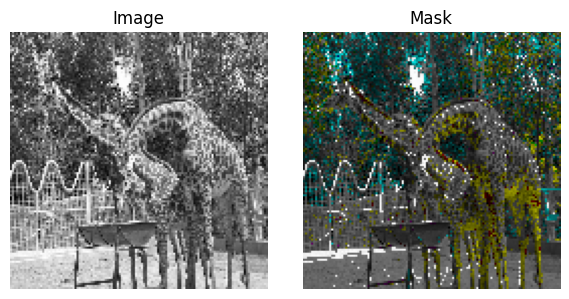

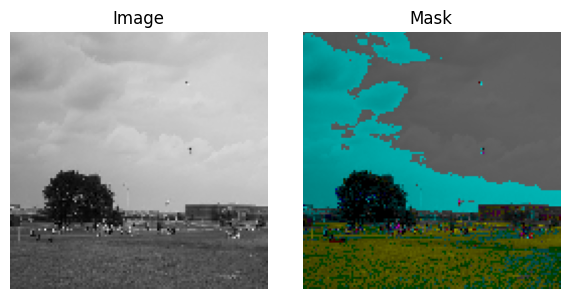

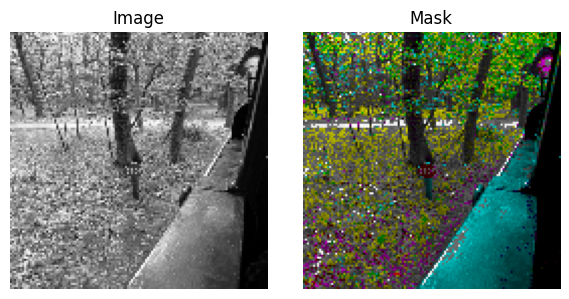

In [4]:
dflu.first_batch_masks(coco_train)

# Pre Model

In [5]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  0


In [6]:
train_steps, val_steps = dl.coco_cardinality()

for _, masks in coco_train.take(1):
    print("min/max mask IDs:", tf.reduce_min(masks), tf.reduce_max(masks))

for _, masks in coco_val.take(1):
    print("min/max mask IDs:", tf.reduce_min(masks), tf.reduce_max(masks))

loading annotations into memory...
Done (t=12.11s)
creating index...
index created!
loading annotations into memory...
Done (t=0.46s)
creating index...
index created!
min/max mask IDs: tf.Tensor(0, shape=(), dtype=int32) tf.Tensor(8, shape=(), dtype=int32)
min/max mask IDs: tf.Tensor(0, shape=(), dtype=int32) tf.Tensor(8, shape=(), dtype=int32)


# Model

In [7]:
# model = tf.keras.models.Sequential()
# model.add(layers.Input(shape=input_shape))
# model.add(layers.MaxPooling2D((2)))
# model.add(layers.Conv2D(dl.IMAGE_SIZE // (4 * BAD_MODEL_COEFFICIENT), (dl.IMAGE_SIZE // 2) * 2 + 1,
#                     activation='relu', padding='same'))
# model.add(MaxPooling2D((2)))
# model.add(BatchNormalization())
# model.add(Conv2D(dataset_loader.IMAGE_SIZE // (2 * BAD_MODEL_COEFFICIENT), (dataset_loader.IMAGE_SIZE // 4) * 2 + 1,
#                     activation='relu', padding='same'))
# model.add(Conv2D(dataset_loader.IMAGE_SIZE // (2 * BAD_MODEL_COEFFICIENT), (dataset_loader.IMAGE_SIZE // 4) * 2 + 1,
#                     activation='relu', padding='same'))
# model.add(MaxPooling2D((2)))
# model.add(BatchNormalization())
# model.add(Conv2D(dataset_loader.IMAGE_SIZE // BAD_MODEL_COEFFICIENT, (dataset_loader.IMAGE_SIZE // 8) * 2 + 1,
#                     activation='relu', padding='same'))
# model.add(Conv2D(dataset_loader.IMAGE_SIZE // BAD_MODEL_COEFFICIENT, (dataset_loader.IMAGE_SIZE // 8) * 2 + 1,
#                     activation='relu', padding='same'))

# model.add(UpSampling2D((2)))
# model.add(BatchNormalization())
# model.add(Conv2D(dataset_loader.IMAGE_SIZE // (2 * BAD_MODEL_COEFFICIENT), (dataset_loader.IMAGE_SIZE // 4) * 2 + 1,
#                     activation='relu', padding='same'))
# model.add(Conv2D(dataset_loader.IMAGE_SIZE // (2 * BAD_MODEL_COEFFICIENT), (dataset_loader.IMAGE_SIZE // 4) * 2 + 1,
#                     activation='relu', padding='same'))
# model.add(UpSampling2D((2)))
# model.add(BatchNormalization())
# model.add(Conv2D(dataset_loader.IMAGE_SIZE // (4 * BAD_MODEL_COEFFICIENT), (dataset_loader.IMAGE_SIZE // 2) * 2 + 1,
#                     activation='relu', padding='same'))
# model.add(UpSampling2D((2)))
# model.add(Conv2D(dataset_loader.COCO_NUM_CLASSES, 1, activation='softmax'))


model = tf.keras.models.Sequential(
    [
        layers.Input(shape=(dl.IMAGE_SIZE, dl.IMAGE_SIZE, 1)),
        layers.Input(shape=(dl.IMAGE_SIZE, dl.IMAGE_SIZE)),
        # layers.Lambda(lambda x: tf.expand_dims(x, axis=-1)),

        layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D(4, 4),

        layers.Conv2D(256, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),
        layers.MaxPooling2D(4, 4),

        # layers.Conv2D(512, (3, 3), activation='relu', padding='same'),
        # layers.BatchNormalization(),
        # layers.MaxPooling2D(4, 4),

        layers.Dropout(0.3),

        # layers.UpSampling2D(4),
        # layers.Conv2DTranspose(512, (3, 3), activation='relu', padding='same'),
        # layers.BatchNormalization(),

        layers.UpSampling2D(4),
        # layers.Conv2DTranspose(256, (3, 3), activation='relu', padding='same'),
        # layers.BatchNormalization(),

        layers.UpSampling2D(4),
        layers.Conv2DTranspose(128, (3, 3), activation='relu', padding='same'),
        layers.BatchNormalization(),

        # layers.Conv2D(dl.COCO_NUM_CLASSES, 1, activation='softmax')
        layers.Conv2D(3, 1, activation='softmax')
    ]
)

model.summary()

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss="mean_squared_error",
    metrics=["mae"]
)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        multiple                  0         
                                                                 
 conv2d (Conv2D)             (None, 128, 128, 128)     1280      
                                                                 
 batch_normalization (BatchN  (None, 128, 128, 128)    512       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 32, 32, 128)      0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 256)       295168    
                                                                 
 batch_normalization_1 (Batc  (None, 32, 32, 256)      1

In [8]:
for images, masks in coco_train.take(1):
    print("train images batch shape:", images.shape)
    print("train masks  batch shape:", masks.shape)

train images batch shape: (32, 128, 128, 1)
train masks  batch shape: (32, 128, 128)


In [9]:
early_stop = tf.keras.callbacks.EarlyStopping(
    patience=3,
    restore_best_weights=True,
)
model.fit(
    coco_train,
    epochs=2,
    steps_per_epoch=train_steps,
    validation_data=coco_val,
    validation_steps=val_steps,
    callbacks=[early_stop]
)

Epoch 1/2


ValueError: in user code:

    File "d:\GitHub\IO_lab_6\.venv\lib\site-packages\keras\engine\training.py", line 1160, in train_function  *
        return step_function(self, iterator)
    File "d:\GitHub\IO_lab_6\.venv\lib\site-packages\keras\engine\training.py", line 1146, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "d:\GitHub\IO_lab_6\.venv\lib\site-packages\keras\engine\training.py", line 1135, in run_step  **
        outputs = model.train_step(data)
    File "d:\GitHub\IO_lab_6\.venv\lib\site-packages\keras\engine\training.py", line 994, in train_step
        loss = self.compute_loss(x, y, y_pred, sample_weight)
    File "d:\GitHub\IO_lab_6\.venv\lib\site-packages\keras\engine\training.py", line 1052, in compute_loss
        return self.compiled_loss(
    File "d:\GitHub\IO_lab_6\.venv\lib\site-packages\keras\engine\compile_utils.py", line 265, in __call__
        loss_value = loss_obj(y_t, y_p, sample_weight=sw)
    File "d:\GitHub\IO_lab_6\.venv\lib\site-packages\keras\losses.py", line 152, in __call__
        losses = call_fn(y_true, y_pred)
    File "d:\GitHub\IO_lab_6\.venv\lib\site-packages\keras\losses.py", line 272, in call  **
        return ag_fn(y_true, y_pred, **self._fn_kwargs)
    File "d:\GitHub\IO_lab_6\.venv\lib\site-packages\keras\losses.py", line 1486, in mean_squared_error
        return backend.mean(tf.math.squared_difference(y_pred, y_true), axis=-1)

    ValueError: Dimensions must be equal, but are 3 and 128 for '{{node mean_squared_error/SquaredDifference}} = SquaredDifference[T=DT_FLOAT](sequential/conv2d_2/Softmax, mean_squared_error/Cast)' with input shapes: [?,128,128,3], [?,128,128].


# LOAD MODEL FROM AGENT 1

In [11]:
def dice_loss(y_true, y_pred, smooth=1e-6):
    # y_true: (batch, h, w)     — int32 labels in [0, num_classes)
    # y_pred: (batch, h, w, c)  — float32 softmax probabilities

    num_classes = tf.shape(y_pred)[-1]
    y_true_onehot = tf.one_hot(tf.cast(y_true, tf.int32), num_classes)  # (b,h,w,c)

    # Flatten
    y_true_f = tf.reshape(y_true_onehot, [-1, num_classes])
    y_pred_f = tf.reshape(y_pred, [-1, num_classes])

    intersection = tf.reduce_sum(y_true_f * y_pred_f, axis=0)
    union = tf.reduce_sum(y_true_f + y_pred_f, axis=0)

    dice = (2. * intersection + smooth) / (union + smooth)
    return 1 - tf.reduce_mean(dice)  # mean over all classes
def combined_loss(y_true, y_pred):
    ce = tf.keras.losses.sparse_categorical_crossentropy(y_true, y_pred)
    d = dice_loss(y_true, y_pred)
    return ce + d

class SegmentationMeanIoU(tf.keras.metrics.MeanIoU):
    def __init__(self, name="SegmentationMeanIoU", *, num_classes, image_size=dl.IMAGE_SIZE, **kwargs):
        # Filter out image_size from kwargs to avoid passing it to MeanIoU
        kwargs.pop('image_size', None)
        super().__init__(num_classes=num_classes, name=name, **kwargs)
        self.num_classes = num_classes
        self.image_size = image_size

    def update_state(self, y_true, y_pred, sample_weight=None):
        y_true = tf.cast(y_true, tf.int32)
        y_true = tf.ensure_shape(y_true, [None, self.image_size, self.image_size])
        y_pred_labels = tf.argmax(y_pred, axis=-1)
        y_pred_labels = tf.ensure_shape(y_pred_labels, [None, self.image_size, self.image_size])
        return super().update_state(y_true, y_pred_labels, sample_weight)

    def get_config(self):
        config = super().get_config()
        config.update({
            "num_classes": self.num_classes,
            "image_size": self.image_size
        })
        return config

    @classmethod
    def from_config(cls, config):
        return cls(
            name=config.get("name", "SegmentationMeanIoU"),
            num_classes=config["num_classes"],
            image_size=config.get("image_size", 128)
        )

In [64]:
# msh_model = tf.keras.models.load_model("models/precompv3_60.keras", custom_objects={'dice_loss': dice_loss, 'combined_loss': combined_loss, "SegmentationMeanIoU": SegmentationMeanIoU})
msh_model = tf.keras.models.load_model("models/st32_100.keras", custom_objects={'dice_loss': dice_loss, 'combined_loss': combined_loss, "SegmentationMeanIoU": SegmentationMeanIoU})

In [45]:
dl.IMAGE_SIZE = 32

1/1 [==============================] - 0s 281ms/step


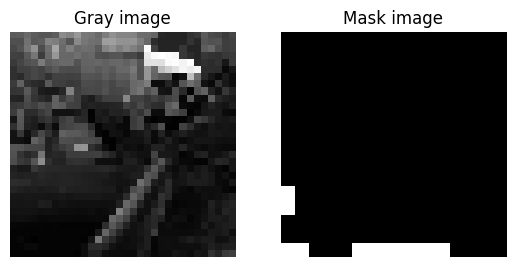

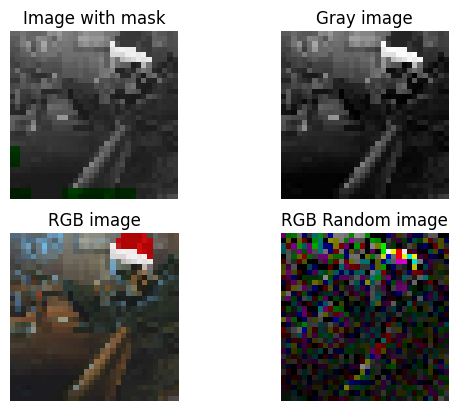

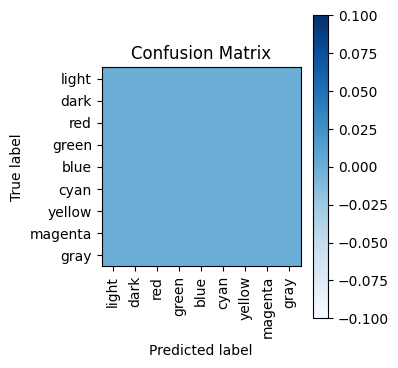

In [65]:
file_name = "datasets\\untitl34ed.png"
file_name = "datasets\\kode-lgx-dr-ghostx.jpg"
file_name = "datasets\\NewYearSkelet.jpg"

image_ = cv2.imread(file_name, cv2.IMREAD_COLOR_RGB)
image_ = cv2.resize(image_, (dl.IMAGE_SIZE, dl.IMAGE_SIZE))

image = cv2.imread(file_name, cv2.IMREAD_GRAYSCALE)

image = cv2.resize(image, (dl.IMAGE_SIZE, dl.IMAGE_SIZE))

plt.subplot(1, 2, 1)
plt.title("Gray image")
plt.imshow(image, cmap="gray")
plt.axis("off")

image = np.expand_dims(image, axis=0)

mask = msh_model.predict(image)
mask = mask.astype(bool)
index_mask = np.argmax(mask, axis=-1)

plt.subplot(1, 2, 2)
plt.title("Mask image")
plt.imshow(index_mask[0], cmap="gray")
plt.axis("off")
plt.show()

rgb_image = dflu.apply_mask_to_image(image, index_mask)

random_mask = np.random.randint(0, dl.COCO_NUM_CLASSES, (1, dl.IMAGE_SIZE, dl.IMAGE_SIZE))
rgb_random_image = dflu.apply_mask_to_image(image, random_mask)

plt.subplot(2, 2, 1)
plt.title("Image with mask")
plt.imshow(rgb_image[0])
plt.axis("off")

plt.subplot(2, 2, 2)
plt.title("Gray image")
plt.imshow(image[0], cmap="gray")
plt.axis("off")

plt.subplot(2, 2, 3)
plt.title("RGB image")
plt.imshow(image_)
plt.axis("off")

plt.subplot(2, 2, 4)
plt.title("RGB Random image")
plt.imshow(rgb_random_image[0])
plt.axis("off")

plt.show()

cm = confusion_matrix(image_.reshape(-1), rgb_image[0].reshape(-1), labels=np.arange(dl.COCO_NUM_CLASSES))  # Include all labels 0–8
used_label_names = dflu.coco_rgb_labels  # All 9 labels
cm_log = np.log1p(cm)
fig, ax = plt.subplots(figsize=(4, 4))
disp = ConfusionMatrixDisplay(confusion_matrix=cm_log, display_labels=used_label_names)
disp.plot(include_values=False, xticks_rotation=90, cmap='Blues', ax=ax)
plt.title("Confusion Matrix")
plt.grid(False)
plt.tight_layout()
plt.show()


In [ ]:
image_.reshape(-1), rgb_image[0].shape

(array([[[ 82, 108, 126],
         [ 86, 107, 127],
         [102, 119, 126],
         ...,
         [ 94,  84,  74],
         [ 87,  74,  58],
         [ 97,  82,  60]],
 
        [[ 84,  95, 100],
         [ 85,  94, 102],
         [ 90, 129, 159],
         ...,
         [104,  94,  85],
         [ 85,  75,  65],
         [ 91,  80,  61]],
 
        [[ 83,  87,  90],
         [ 91,  96,  99],
         [ 96, 133, 147],
         ...,
         [ 96,  87,  80],
         [ 85,  75,  65],
         [ 90,  77,  62]],
 
        ...,
 
        [[ 28,  27,  32],
         [ 31,  30,  36],
         [ 27,  26,  31],
         ...,
         [ 38,  38,  38],
         [ 39,  40,  35],
         [ 57,  45,  26]],
 
        [[ 28,  27,  32],
         [ 28,  27,  32],
         [ 28,  33,  37],
         ...,
         [ 54,  45,  34],
         [ 58,  48,  39],
         [ 60,  48,  42]],
 
        [[ 28,  27,  32],
         [ 28,  27,  32],
         [ 28,  27,  32],
         ...,
         [ 64,  51,  38],
  

In [14]:
raise Exception

Exception: 

# Thrash

In [ ]:
def rgb_to_label(mask_rgb, color_map):
    """
    Convert RGB mask to class indices using coco_rgb_colors.
    mask_rgb: np.array shape (H, W, 3)
    color_map: np.array shape (9, 3)
    """
    label_mask = np.zeros(mask_rgb.shape[:2], dtype=np.uint8)
    for i, color in enumerate(color_map):
        matches = np.all(mask_rgb == color, axis=-1)
        label_mask[matches] = i
    return label_mask


In [ ]:
def preprocess_gray_image(gray_img):
    gray_img = gray_img.astype(np.float32) / 255.0  # normalize
    return np.expand_dims(gray_img, axis=-1)        # (H, W) → (H, W, 1)


In [ ]:
from tensorflow.keras import layers, models

def build_unet(input_shape=(None, None, 1), num_classes=9):
    inputs = layers.Input(shape=input_shape)

    # Encoder
    x = layers.Conv2D(8, 3, activation='relu', padding='same')(inputs)
    x = layers.MaxPooling2D()(x)
    x = layers.Conv2D(16, 3, activation='relu', padding='same')(x)
    x = layers.MaxPooling2D()(x)

    # Decoder
    x = layers.Conv2DTranspose(16, 3, strides=2, activation='relu', padding='same')(x)
    x = layers.Conv2DTranspose(8, 3, strides=2, activation='relu', padding='same')(x)

    outputs = layers.Conv2D(num_classes, 1, activation='softmax')(x)

    return models.Model(inputs, outputs)


In [ ]:
model = build_unet(input_shape=(dl.IMAGE_SIZE, dl.IMAGE_SIZE, 1), num_classes=9)
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])


In [ ]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 512, 512, 1)]     0         
                                                                 
 conv2d (Conv2D)             (None, 512, 512, 8)       80        
                                                                 
 max_pooling2d (MaxPooling2D  (None, 256, 256, 8)      0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 256, 256, 16)      1168      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 128, 128, 16)     0         
 2D)                                                             
                                                                 
 conv2d_transpose (Conv2DTra  (None, 256, 256, 16)     2320  

In [ ]:
history = model.fit(
    train,
    batch_size=dl.BATCH_SIZE,
    epochs=2,
    steps_per_epoch=train_steps,
    validation_data=val,
    validation_steps=val_steps
)

Epoch 1/2
  1/924 [..............................] - ETA: 3:56:54 - loss: 2.1990 - accuracy: 0.0056

KeyboardInterrupt: 

In [ ]:
pred = model.predict(val)  # shape (1, H, W, 9)
pred_class = np.argmax(pred[0], axis=-1)          # shape (H, W)

# Convert label map back to RGB
pred_rgb = dflu.coco_rgb_colors[pred_class]


ValueError: When providing an infinite dataset, you must specify the number of steps to run (if you did not intend to create an infinite dataset, make sure to not call `repeat()` on the dataset).